## Скачивание всех зависимостей проекта

In [1]:
!pip install -r requirements.txt

## Авторизация в wandb 

In [2]:
!wandb login | cat wandb_secret.txt

"cat" �� ���� ����७��� ��� ���譥�
��������, �ᯮ��塞�� �ணࠬ��� ��� ������ 䠩���.


## Импорт библиотек

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import optuna
import keras 

from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt

import pymorphy2
import Levenshtein
import gensim.downloader
import wandb
import json
import pickle
from os import path

from visualization import plot_reliability, bootstrap_plot, plot_roc_curve, boxplot_reliability

import warnings
warnings.filterwarnings("ignore")

c:\Users\pasin\DS\Доп\paronyms_with_docker\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Чтение данных

In [5]:
# конфигурация
with open('config.json', 'r') as file:
    config = json.load(file)

cat = config['catboost']
nn = config['nn']
data_path = config['data_path']


In [6]:
# датафрейм 
data = pd.read_csv(data_path, index_col=0)

## Препроцессинг

In [6]:
# installing model
word2vec_rus = gensim.downloader.load('word2vec-ruscorpora-300')

In [7]:
morph = pymorphy2.MorphAnalyzer()

In [8]:
# get a part of speech needed to make an embedding of word
def get_part_of_speech(word):
    
    parsed_word = morph.parse(word)[0]
    pos = parsed_word.tag.POS

    if pos == "ADJF":
        return "ADJ"
    
    return pos 

In [9]:
# making embedding by pretrained word2vec model 
def get_embedding(word):

    w2v_word = f"{word}_{get_part_of_speech(word)}"

    try:
        emb = word2vec_rus[w2v_word]

    except KeyError:
        return None
    
    return emb

In [10]:
# add extra columns for embeddings 
for i in range(600):
    data[f"emb_{int(i > 299) + 1}_{i % 300}"] = 0
# add extra columns for Levenshtein distance
data["lev_dist"] = 0

rows_to_drop = []

# add embeddings to dataframe 
for i in range(len(data)):

    # get embs for two words
    word1 = data.word1[i]
    word2 = data.word2[i]
    emb1 = get_embedding(word1)
    emb2 = get_embedding(word2)

    if emb1 is not None and emb2 is not None:
        # add embeddings
        data.loc[i, "emb_1_0":"emb_1_299"] = emb1
        data.loc[i, "emb_2_0":"emb_2_299"] = emb2
        data.loc[i, "lev_dist"] = Levenshtein.distance(word1, word2)
        # print("YES", data.word1[i], data.word2[i])

    else: 
        # delete words that are not in word2vec vocabulary
        rows_to_drop.append(i)
        # print("NO", data.word1[i], data.word2[i])

data = data.drop(rows_to_drop, axis=0).reset_index(drop=True)
data.head()

,word1,word2,label,emb_1_0,emb_1_1,emb_1_2,emb_1_3,emb_1_4,emb_1_5,emb_1_6,...,emb_2_291,emb_2_292,emb_2_293,emb_2_294,emb_2_295,emb_2_296,emb_2_297,emb_2_298,emb_2_299,lev_dist
0,целый,цельный,1,-0.019124,0.034811,0.057754,0.119841,-0.034180,0.042868,0.015424,...,0.032209,0.014659,0.024586,-0.071244,-0.106860,0.002109,0.057067,-0.029967,0.069121,2
1,сравнимый,неорганичный,0,-0.043983,-0.009047,-0.063538,0.147805,-0.161587,0.027221,0.032012,...,-0.034892,0.018441,0.069707,-0.001893,-0.062972,0.145138,0.147791,-0.062155,0.080968,7
2,чубастый,завоевательный,0,-0.051917,0.044872,0.014789,0.002823,-0.002203,0.050730,0.031053,...,0.046212,-0.020866,-0.080959,-0.085725,-0.003354,0.015747,0.017519,-0.042495,0.167213,11
3,обидчивый,азарт,0,0.023674,0.052748,-0.034327,-0.031669,-0.014316,0.073295,-0.061295,...,-0.039973,-0.012380,-0.012538,-0.200660,-0.089638,-0.017675,0.042906,-0.012042,-0.019632,9
4,личностный,личный,1,-0.045874,-0.051794,-0.059747,0.019997,-0.075421,-0.042737,-0.057829,...,0.022120,-0.057636,0.027975,-0.042808,-0.101067,0.031723,0.043072,-0.031811,0.032527,4


## PCA сокращение размерности эмбедингов

In [11]:
# fitting PCA
def fit_pca(X, n):
    pca = PCA(n_components=n)
    pca.fit(X)
    return pca

# transform dataset to n_componets dimansion
def reduce_dimension(pca, X):
    X_transformed = pca.transform(X)
    return X_transformed

In [12]:
X = data.drop(["word1", "word2", "label"], axis=1)
y = data["label"]

pca_n_components = config["pca_n_components"]

# fit PCA
pca = fit_pca(pd.concat([X.loc[:, "emb_1_0":"emb_1_299"], X.loc[:, "emb_2_0":"emb_2_299"].rename(columns={f"emb_2_{i}":f"emb_1_{i}" for i in range(300)}) ], ignore_index=True), pca_n_components)

# reduce dimensuon with PCA
X.loc[:, "emb_1_0":f"emb_1_{pca_n_components-1}"] = reduce_dimension(pca, X.loc[:, "emb_1_0":"emb_1_299"])
X.loc[:, f"emb_2_0":f"emb_2_{pca_n_components-1}"] = reduce_dimension(pca, X.loc[:, "emb_2_0":"emb_2_299"].rename(columns={f"emb_2_{i}":f"emb_1_{i}" for i in range(300)}))

# drop extra columns of embedding
X = X.drop(list(X.columns[pca_n_components:300]) + list(X.columns[300+pca_n_components:-1]), axis=1)
X.head()

,emb_1_0,emb_1_1,emb_1_2,emb_1_3,emb_1_4,emb_1_5,emb_1_6,emb_1_7,emb_1_8,emb_1_9,...,emb_2_141,emb_2_142,emb_2_143,emb_2_144,emb_2_145,emb_2_146,emb_2_147,emb_2_148,emb_2_149,lev_dist
0,0.092990,0.064130,-0.009231,-0.117479,0.119544,-0.012405,0.001262,0.036711,0.056215,0.036373,...,-0.041627,-0.021121,-0.037906,-0.036691,-0.049780,-0.055427,0.058641,-0.065962,0.002906,2
1,-0.073190,0.121473,0.159301,-0.092435,-0.064992,0.211331,0.043881,-0.079572,0.139452,-0.007544,...,-0.011263,-0.019038,0.077430,0.008595,0.064412,-0.009687,0.044169,0.068361,-0.041446,7
2,0.404789,-0.048654,-0.008222,-0.030357,-0.002152,0.115743,-0.036572,0.107040,-0.181176,-0.009337,...,0.014172,-0.088971,-0.055831,-0.015053,-0.007175,-0.113260,-0.085061,0.002485,0.007348,11
3,0.093875,-0.295198,-0.023502,0.178027,-0.329819,-0.137436,0.063094,-0.033621,-0.093356,-0.018628,...,0.028608,-0.025530,0.048492,0.046852,0.052386,-0.015520,0.070259,0.032970,0.005440,9
4,-0.438857,-0.025888,0.076917,-0.048277,-0.095657,-0.114348,-0.050334,-0.016789,0.099320,-0.067085,...,0.038456,-0.012188,-0.020152,-0.020013,0.003845,0.003102,0.053514,-0.010218,0.049044,4


In [13]:
# PCA explained variance 
np.sum(pca.explained_variance_ratio_)

0.8155569805685559

Feature ingineering 

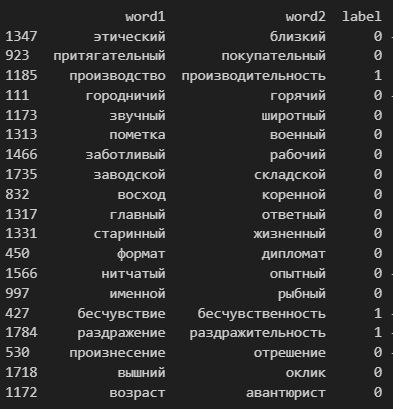

На одном из прогонов модели после вывода слов, в которых модель ошиблась, я заметил что модель часто допускает ошибку первого рода (ложноположительные объекты). Хотя по словам, в которых модель ошиблась, легко понять что они не паронимы, тк между ними большое расстояние Левенштейна. Возможно, модель не обращает достаточного внимания на слова с большим расстоянием Левенштейна, поэтому введем два новых признака

 - квадрат расстояния Левенштейна
 - процент добавленных символов (расстояние Левенштейна, деленое на максимальную длину слова)

In [14]:
X["lev_dist_2"] = X.lev_dist**2
X["lev_dist_%"] = 0
for i in range(len(data.word1)):
    X["lev_dist_%"][i] = X.lev_dist[i] / max(len(data.word1[i]), len(data.word2[i]))

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=config['test_size'], random_state=42)

## Катбуст

In [16]:
if config["logging"]:
    wandb.init(project="paronyms", tags=["cat", "with dist 2", "with dist %"])

In [17]:
# with open('best_params.json', 'r') as file:
#     best_params = json.load(file)

# uncomment to train with optuna
def objective(trial):
    params = {
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 0.1, 10.0),
        'bagging_temperature': trial.suggest_loguniform('bagging_temperature', 0.01, 1.0)
    }

    model = CatBoostClassifier(verbose=0, **params)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    mae = mean_absolute_error(y_test, predictions)

    return mae

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=cat["n_trials"])
best_params = study.best_params

cat_model = CatBoostClassifier(verbose=0, **best_params)
cat_model.fit(X_train, y_train)
best_predictions = cat_model.predict(X_test)
best_mae = mean_absolute_error(y_test, best_predictions)
cat_predictions = cat_model.predict_proba(X_test)

print('Best Parameters:', best_params)

Best Parameters: {'learning_rate': 0.011289064280955217, 'depth': 7, 'l2_leaf_reg': 0.5808384667318421, 'bagging_temperature': 0.09136846123232852}


In [18]:
treshold = cat["treshold"]

mae = mean_absolute_error(y_test, cat_predictions[:, 1])
acc = accuracy_score(y_test, [1 if prob > treshold else 0 for prob in cat_predictions[:, 1]])
print('MAE:', mae, ' Accuracy:', acc)

if config["logging"]:
    wandb.log({'MAE': mae, 'Accuracy': acc, "params": best_params.update({"pca_comp": config["pca_n_components"]})})
    wandb.finish()

MAE: 0.037774788640206995  Accuracy: 0.9728260869565217


In [19]:
# get feature importance
feature_importances = cat_model.feature_importances_

for i, importance in enumerate(feature_importances[-3::]):
    print(f"{X.columns[-len(feature_importances[-3::])+i]}: {importance}")

lev_dist: 5.545468713805878
lev_dist_2: 3.618893785660241
lev_dist_%: 41.448224352618546


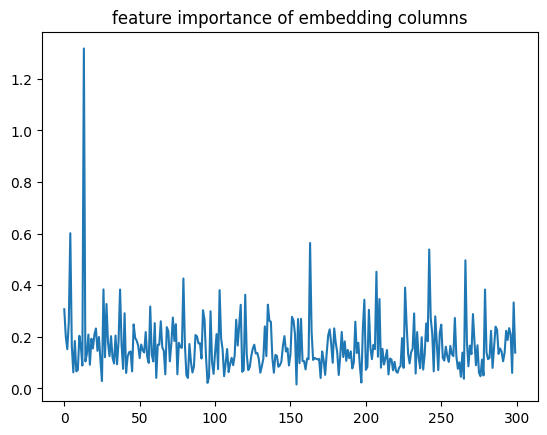

In [20]:
# plotting feature importance of embeddings
plt.plot(cat_model.feature_importances_[:-3])
plt.title('feature importance of embedding columns')
None

In [21]:
cat_pred_table = data.iloc[X_test.index][["word1", "word2"]]
cat_pred_table['preds'] = cat_predictions[:, 1]
cat_pred_table['label'] = y_test
cat_pred_table.reset_index(inplace=True, drop=True)
cat_pred_table.head()

,word1,word2,preds,label
0,флегматический,конский,0.002214,0
1,гуманизм,гуманность,0.989128,1
2,воспитательный,благодарственный,0.009391,0
3,ящер,человечий,0.001903,0
4,певческий,певчий,0.998588,1


In [22]:
errors = y_test != [1 if prob > treshold else 0 for prob in cat_predictions[:, 1]]
words_with_errors = data.iloc[errors[errors==True].index][["word1", "word2", "label"]]
print("Cлова, в которых модель ошиблась:\n")
print(words_with_errors)

Cлова, в которых модель ошиблась:

               word1           word2  label
1347       этический         близкий      0
923   притягательный   покупательный      0
111       городничий         горячий      0
548        иноверный  единоверческий      0
1466      заботливый         рабочий      0
1735       заводской       складской      0
694     почтительный    добровольный      0
940   реалистический     токсический      0
367        житейский       жизненный      1
530     произнесение       отрешение      0


## Нейросеть

In [23]:
# Логирование
if config["logging"]:
    wandb.init(project="paronyms", tags=["nn", "with dist 2", "with dist %"])
    wandb.log(nn)

In [38]:
nn_model = tf.keras.Sequential()

optimizer = keras.optimizers.Adam(learning_rate=nn["lr"])
# optimizer = keras.optimizers.Adagrad(learning_rate=nn["lr"], initial_accumulator_value=0.1) 
layers = nn["layers"]
activations = nn["activations"]

for i in range(len(layers)):
    if i == 0:
        nn_model.add(tf.keras.layers.Dense(layers[i], activation=activations[i], input_shape=(X_train.shape[1],)))
    else:
        nn_model.add(tf.keras.layers.Dense(layers[i], activation=activations[i]))

nn_model.compile(optimizer=optimizer, loss='mean_absolute_error')

history = nn_model.fit(X_train, y_train, epochs=nn["epochs"], batch_size=nn["batch_size"], verbose=0)

nn_predictions = nn_model.predict(X_test)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


MAE: 0.054879806886068694  Accuracy: 0.9456521739130435


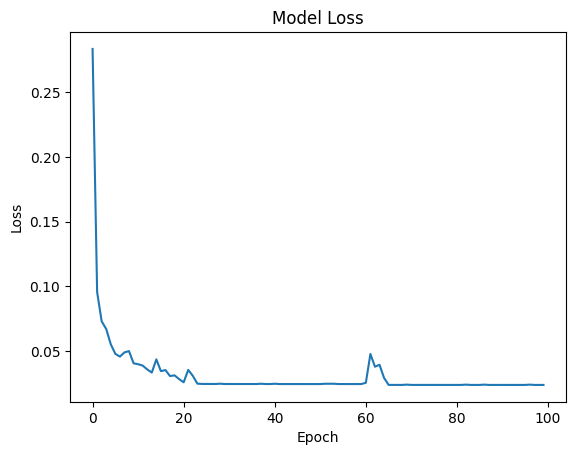

In [39]:
treshold = nn["treshold"]

mae = mean_absolute_error(y_test, nn_predictions)
acc = accuracy_score(y_test, [1 if prob > treshold else 0 for prob in nn_predictions])
print('MAE:', mae, ' Accuracy:', acc)

if config["logging"]:
    wandb.log({'MAE': mae, 'Accuracy': acc, "params": nn.update({"pca_comp": config["pca_n_components"], "optim": "adagrad"})})
    wandb.finish()

# Plotting the loss
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [40]:
nn_pred_table = data.iloc[X_test.index][["word1", "word2"]]
nn_pred_table['preds'] = nn_predictions
nn_pred_table['label'] = y_test
nn_pred_table.reset_index(inplace=True, drop=True)
nn_pred_table.head()

,word1,word2,preds,label
0,флегматический,конский,1.167275e-35,0
1,гуманизм,гуманность,1.000000e+00,1
2,воспитательный,благодарственный,0.000000e+00,0
3,ящер,человечий,4.520010e-23,0
4,певческий,певчий,1.000000e+00,1


In [41]:
print("Cлова, в которых модель ошиблась:\n")
print(nn_pred_table[(nn_pred_table['preds'] > treshold) != nn_pred_table['label']])

Cлова, в которых модель ошиблась:

              word1               word2         preds  label
16        этический             близкий  9.998339e-01      0
36   притягательный       покупательный  1.000000e+00      0
43     производство  производительность  1.250616e-16      1
69       городничий             горячий  1.000000e+00      0
89          звучный            широтный  9.999998e-01      0
122      заботливый             рабочий  1.000000e+00      0
158       заводской           складской  1.000000e+00      0
176      придворный            яростный  9.999869e-01      0
192         главный            ответный  9.999585e-01      0
193       старинный           жизненный  9.999983e-01      0
194     пророческий     пророчественный  2.788041e-02      1
213          формат            дипломат  9.999979e-01      0
240    почтительный        добровольный  9.999944e-01      0
279  реалистический         токсический  9.994739e-01      0
287     бесчувствие    бесчувственность  1.242760e

## Сравнение моделей

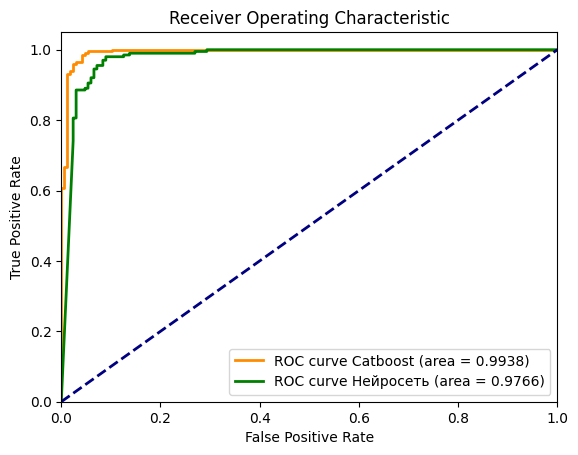

In [42]:
plot_roc_curve(y_test, cat_predictions[:, 1], y_test, nn_predictions)

Roc-auc больше у catboost на 0.02

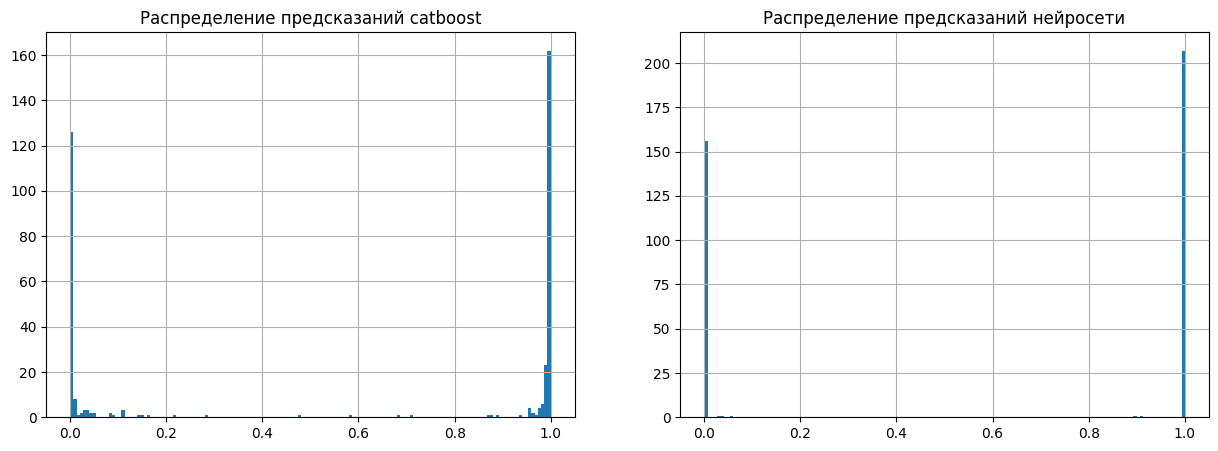

In [43]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

cat_pred_table.preds.hist(bins=150, ax=axs[0])
axs[0].set_title("Распределение предсказаний catboost")

nn_pred_table.preds.hist(bins=150, ax=axs[1])
axs[1].set_title("Распределение предсказаний нейросети")

plt.show()

По распределению предсказаний видно, что нейросеть более уверена в своих ответах. Но учитывая что accuracy у нее хуже, чем у catboost, можно сделать вывод что такая уверенность не является преимуществом над catboost (тк нейросеть будет уверена и в неправильно предсказанных объектах, что видно из таблицы слов, в которых нейросеть ошиблась). Распределение предсказаний catboost более мягкое, что может говорить о том что ее обобщающая способность лучше

5-й квантиль Нейросети: 0.91
95-й квантиль Нейросети: 0.98
5-й квантиль Catboost: 0.95
95-й квантиль Catboost: 0.99


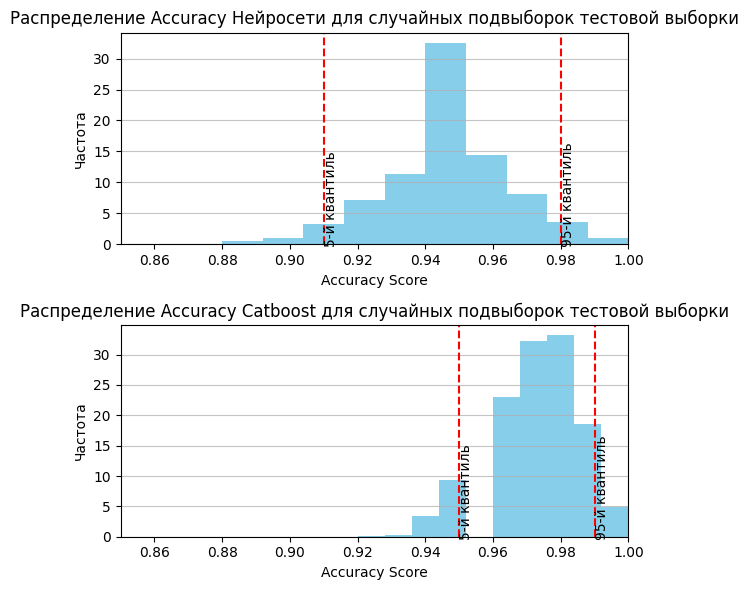

In [44]:
plt.figure(figsize=(6, 6))

plt.subplot(2, 1, 1)
bootstrap_plot(X_test, y_test, nn_model, treshold, "Нейросети")

plt.subplot(2, 1, 2)
bootstrap_plot(X_test, y_test, cat_model, treshold, "Catboost")

plt.tight_layout()
plt.show()

И по квантилям, и по самому распределению выигрывает модель catboost. Так как 

- размах между квантилями меньше, чем у нейросети, что говорит о **большей устойчивости модели**
- сами значения квантилей больше, чем у нейросети, что говорит о **большей точности модели**

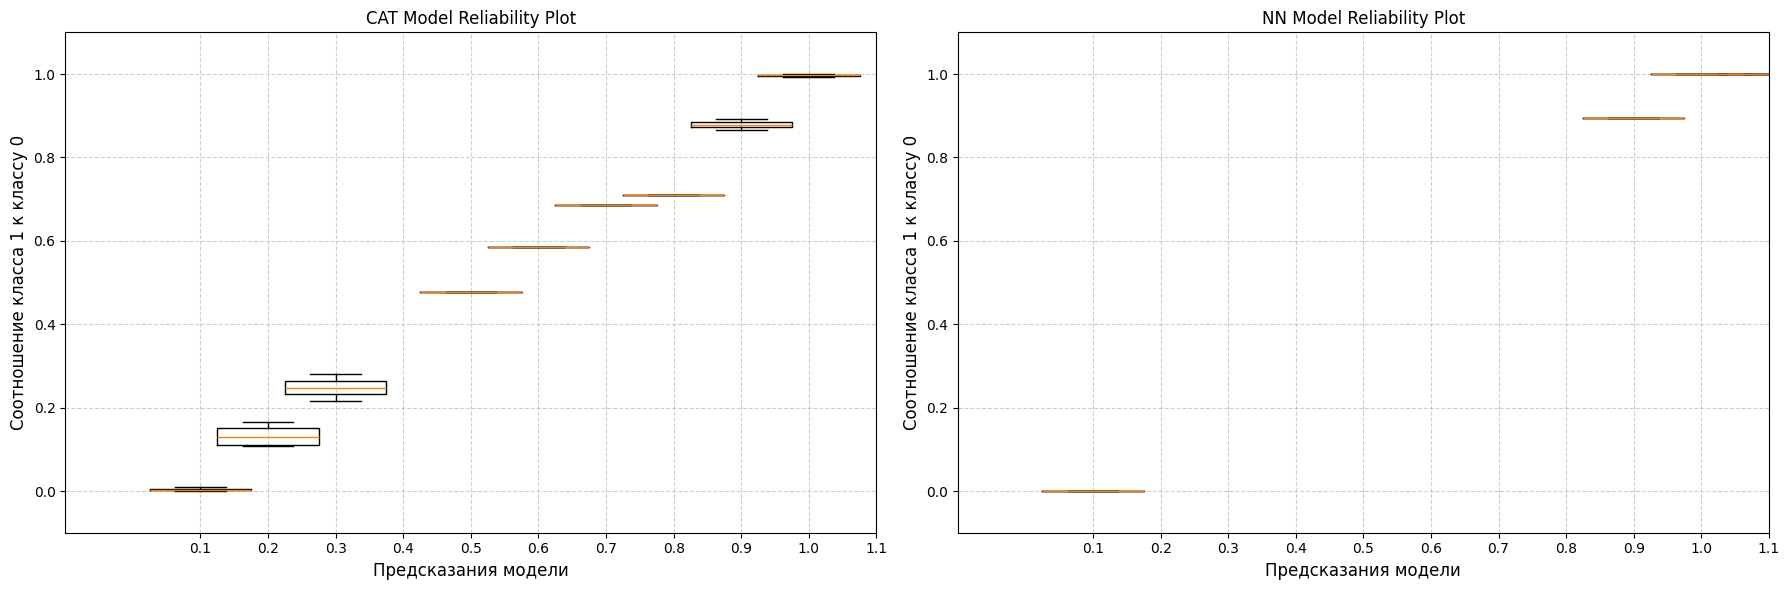

In [45]:
plt.figure(figsize=(18, 6))

plt.subplot(1, 2, 1)
boxplot_reliability(cat_pred_table)
plt.title('CAT Model Reliability Plot')

plt.subplot(1, 2, 2)
boxplot_reliability(nn_pred_table)
plt.title('NN Model Reliability Plot')

plt.tight_layout()
plt.show()

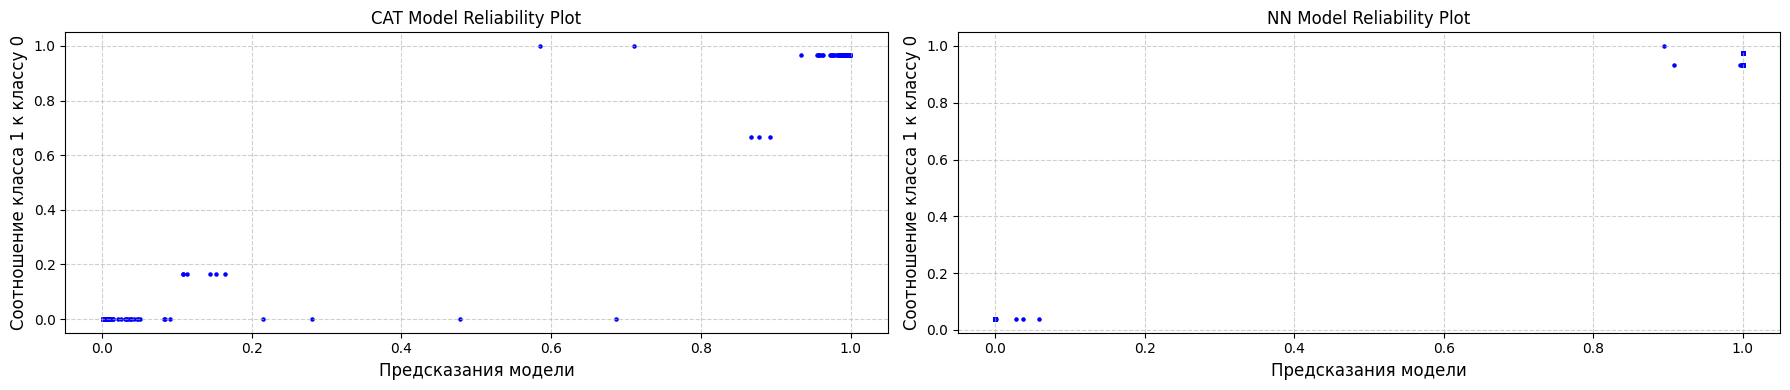

In [46]:
plt.figure(figsize=(18, 4))

plt.subplot(1, 2, 1)
plot_reliability(cat_pred_table)
plt.title('CAT Model Reliability Plot')

plt.subplot(1, 2, 2)
plot_reliability(nn_pred_table)
plt.title('NN Model Reliability Plot')

plt.tight_layout()
plt.show()

## Тестирование

In [33]:
# function for testing new words
def test(word1, word2, model):

    # getting embs and lev dist 
    emb1, emb2 = get_embedding(word1), get_embedding(word2)
    pca_emb1 = reduce_dimension(pca, emb1.reshape(1, -1))
    pca_emb2 = reduce_dimension(pca, emb2.reshape(1, -1))
    lev_dist = Levenshtein.distance(word1, word2)
    X["lev_dist_2"] = X.lev_dist**2
    X["lev_dist_%"] = 0
    for i in range(len(data.word1)):
        X["lev_dist_%"][i] = X.lev_dist[i] / max(len(data.word1[i]), len(data.word2[i]))

    # creating dataframe
    row = pca_emb1.tolist()[0] + pca_emb2.tolist()[0] + [lev_dist, lev_dist**2, lev_dist / max(len(word1), len(word2))]
    X_new = pd.DataFrame([row], columns=X.columns)
    
    # predictions 
    if model == "cat":
        prediction = cat_model.predict_proba(X_new)
        res = np.argmax(prediction[0])
        proba = max(prediction[0])

    if model == "nn":
        prediction = nn_model.predict(X_new)
        if prediction[0][0] < 0.5:
            res = 0
            proba = 1 - (prediction[0][0] if prediction[0][0] > 0 else 0)
        else:
            res = 1
            proba = (prediction[0][0] if prediction[0][0] < 1 else 1)

    # result
    print(f"Слова {word1} и {word2} {'не '*(not res)}являются паронимами с вероятностью {proba}")

In [34]:
# не паронимы
word1 = "приветливый"
word2 = "страна" 

# паронимы
word1 = "целый"
word2 = "цельный" 

# модель 
model = "cat" # nn - keras nn, cat - catboostclassifier

# тестирование
test(word1, word2, model)

Слова целый и цельный являются паронимами с вероятностью 0.9973453003527334


## Мусорка

In [35]:
data

,word1,word2,label,emb_1_0,emb_1_1,emb_1_2,emb_1_3,emb_1_4,emb_1_5,emb_1_6,...,emb_2_291,emb_2_292,emb_2_293,emb_2_294,emb_2_295,emb_2_296,emb_2_297,emb_2_298,emb_2_299,lev_dist
0,целый,цельный,1,-0.019124,0.034811,0.057754,0.119841,-0.034180,0.042868,0.015424,...,0.032209,0.014659,0.024586,-0.071244,-0.106860,0.002109,0.057067,-0.029967,0.069121,2
1,сравнимый,неорганичный,0,-0.043983,-0.009047,-0.063538,0.147805,-0.161587,0.027221,0.032012,...,-0.034892,0.018441,0.069707,-0.001893,-0.062972,0.145138,0.147791,-0.062155,0.080968,7
2,чубастый,завоевательный,0,-0.051917,0.044872,0.014789,0.002823,-0.002203,0.050730,0.031053,...,0.046212,-0.020866,-0.080959,-0.085725,-0.003354,0.015747,0.017519,-0.042495,0.167213,11
3,обидчивый,азарт,0,0.023674,0.052748,-0.034327,-0.031669,-0.014316,0.073295,-0.061295,...,-0.039973,-0.012380,-0.012538,-0.200660,-0.089638,-0.017675,0.042906,-0.012042,-0.019632,9
4,личностный,личный,1,-0.045874,-0.051794,-0.059747,0.019997,-0.075421,-0.042737,-0.057829,...,0.022120,-0.057636,0.027975,-0.042808,-0.101067,0.031723,0.043072,-0.031811,0.032527,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1833,схоластичный,вольный,0,-0.073109,0.004921,0.097991,0.063848,-0.011808,-0.011764,-0.107618,...,-0.038564,-0.051524,0.023416,-0.055744,0.009030,0.055064,0.082237,-0.079475,-0.078026,7
1834,лирик,пансионер,0,-0.020536,-0.013011,-0.029709,0.123185,0.030217,0.041897,-0.040520,...,0.040408,-0.064443,-0.024375,-0.085577,-0.097344,-0.063310,0.014218,0.012637,0.001939,8
1835,цвета,экономный,0,0.002025,0.052643,0.050150,0.033533,0.003616,-0.011666,0.001057,...,0.032414,-0.032294,0.023604,-0.076444,-0.021298,0.008551,-0.001377,-0.036765,0.035764,9
1836,гнилой,гнилостный,1,0.022569,-0.047862,0.049707,0.058395,0.006504,0.046971,0.035626,...,-0.091607,0.088824,0.001456,-0.006952,0.041889,0.050071,0.102235,-0.003491,-0.002087,4


In [36]:
get_embedding(data['word1'][0])

array([-0.01912447,  0.03481076,  0.05775387,  0.11984138, -0.03417952,
        0.04286843,  0.01542427, -0.05592788, -0.02393845, -0.06613431,
       -0.0373123 , -0.03102498, -0.07057048,  0.01719985, -0.03937108,
        0.08016019, -0.04228985, -0.03410865,  0.05223807,  0.04261858,
        0.10558854, -0.04771411, -0.00435403,  0.01390167, -0.10446029,
       -0.04468444,  0.13237846,  0.02690842, -0.06521852,  0.00599958,
       -0.01748716, -0.09039024,  0.06353894, -0.13403532,  0.06880548,
        0.06026421, -0.00294538, -0.00582946,  0.0199578 , -0.02490541,
        0.01803912,  0.02243167, -0.00342069, -0.10418966,  0.08436111,
       -0.00319704,  0.04412412, -0.06022013, -0.04872477, -0.05139613,
        0.00233306, -0.06012024,  0.00861648,  0.08664687,  0.09014085,
        0.02001909, -0.08146334,  0.05011859, -0.06705777,  0.06193779,
        0.09494797, -0.02243975, -0.06591474,  0.05410341,  0.04217657,
        0.00256758,  0.00883377,  0.12455034,  0.04309714,  0.01

In [37]:
morph = pymorphy2.MorphAnalyzer()

word = 'знамя_NOUN'
parsed_word = morph.parse(word)[0]
pos = parsed_word.tag.POS

print(pos)

None
